In [25]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

import librosa

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Conv1D, Conv2D, MaxPooling1D, Flatten, LSTM, Activation, Dropout, Dense

In [2]:
# from src.feature_extraction import feature_extraction
# df = feature_extraction()
df = pd.read_csv('data/data.csv')

In [3]:
from src.clean_data import clean_file
df = clean_file(df).drop(columns = 'Unnamed: 0')
#df.to_csv('data/data.csv')

In [8]:
df.head()

,chroma_stft,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc0,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,emotion
0,0.560788,2175.452134,2643.753126,5033.551870,0.120046,-647.833984,73.953712,2.432933,18.513586,17.144714,...,7.169649,1.848053,1.824471,2.604047,0.179370,1.365900,-1.071097,2.271643,1.772467,4
1,0.477528,2564.985375,2417.364883,4962.326660,0.204620,-621.006470,79.576233,-0.761120,17.735834,7.998703,...,6.117692,-4.211919,1.206020,2.806384,-0.245747,-1.002717,-1.422059,2.155927,0.731970,2
2,0.518734,2485.831877,2439.444660,5112.148062,0.228850,-615.796387,76.241829,-4.434103,12.975468,10.279062,...,0.187123,-1.953549,1.195269,-0.740985,0.539231,0.242258,-2.490123,2.111624,2.165533,1
3,0.465520,2379.847442,2526.826825,5007.380747,0.182659,-591.418762,74.321846,-3.563674,16.381424,12.795290,...,0.173293,-1.589008,-1.135694,-0.693458,0.005279,-1.524946,-3.134480,-0.098739,0.932513,4
4,0.483472,2845.220321,2587.824520,5583.145470,0.195898,-391.396332,41.262829,-12.060490,7.562790,1.676682,...,-0.057663,-3.733739,-6.457394,-4.281969,-3.244542,-6.811999,-0.880189,-2.193330,1.708981,5


In [11]:
emotion = df['emotion']
encoder = LabelEncoder()
y = encoder.fit_transform(emotion)

In [12]:
scaler = StandardScaler()
X = scaler.fit_transform(np.array(df.iloc[:, 1:], dtype = float))
X = X.reshape(X.shape[0], X.shape[1],1)

In [13]:
X.shape

(1440, 25, 1)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [17]:
from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

Using TensorFlow backend.


In [20]:
model = keras.Sequential()

model.add(Conv1D(16, 5,padding='same',
                 input_shape=(25,1)))
model.add(Activation('relu'))
model.add(Conv1D(32, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Conv1D(64, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))

model.add(MaxPooling1D(pool_size=(8)))

model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Dense(64))
model.add(Activation('relu'))
## unstacking rows of pixels in the image and lining them up
model.add(keras.layers.Flatten(input_shape=(X.shape[1], X.shape[2])))
## The second (and last) layer is a 10-node softmax layer that 
##    returns an array of 10 probability scores that sum to 1
model.add(keras.layers.Dense(8, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 25, 16)            96        
_________________________________________________________________
activation_1 (Activation)    (None, 25, 16)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 25, 32)            2592      
_________________________________________________________________
activation_2 (Activation)    (None, 25, 32)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25, 32)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 25, 64)            10304     
_________________________________________________________________
activation_3 (Activation)    (None, 25, 64)           

In [22]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history=model.fit(X_train, y_train, batch_size=16, epochs=15, validation_data=(X_test, y_test))

Train on 1152 samples, validate on 288 samples
Epoch 1/15
1152/1152 [==============================] - 1s 760us/step - loss: 2.0130 - accuracy: 0.1884 - val_loss: 1.8898 - val_accuracy: 0.2292
Epoch 2/15
1152/1152 [==============================] - 0s 383us/step - loss: 1.6650 - accuracy: 0.3620 - val_loss: 1.4697 - val_accuracy: 0.4375
Epoch 3/15
1152/1152 [==============================] - 0s 380us/step - loss: 1.1030 - accuracy: 0.5677 - val_loss: 0.9054 - val_accuracy: 0.6597
Epoch 4/15
1152/1152 [==============================] - 0s 376us/step - loss: 0.7604 - accuracy: 0.6849 - val_loss: 0.6634 - val_accuracy: 0.7396
Epoch 5/15
1152/1152 [==============================] - 1s 474us/step - loss: 0.5379 - accuracy: 0.7891 - val_loss: 0.4197 - val_accuracy: 0.8542
Epoch 6/15
1152/1152 [==============================] - 1s 455us/step - loss: 0.4564 - accuracy: 0.8134 - val_loss: 0.4293 - val_accuracy: 0.8264
Epoch 7/15
1152/1152 [==============================] - 0s 385us/step - loss:

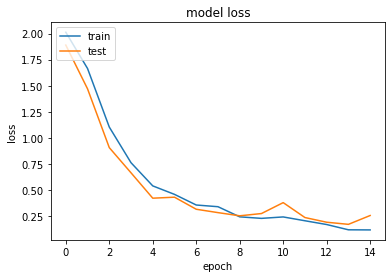

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [27]:
score = model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

accuracy: 90.62%


In [28]:
preds = model.predict(X_test, 
                         batch_size=32, 
                         verbose=1)

preds1=preds.argmax(axis=1)
abc = preds1.astype(int).flatten()
predictions = (encoder.inverse_transform((abc)))

288/288 [==============================] - 0s 231us/step


In [30]:
preddf = pd.DataFrame({'predictedvalues': predictions})
actual=y_test.argmax(axis=1).astype(int).flatten()
actualvalues = (encoder.inverse_transform((actual)))
actualdf = pd.DataFrame({'actualvalues': actualvalues})
finaldf = actualdf.join(preddf)
finaldf.head()

,actualvalues,predictedvalues
0,6,6
1,4,4
2,8,8
3,5,5
4,8,8


In [31]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
1,23
2,35
3,40
4,41
5,39
6,39
7,43
8,28


In [32]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
1,22
2,38
3,40
4,38
5,40
6,38
7,28
8,44


In [33]:
import pickle

# make pickled file ('wb' = write)
pickle.dump(model, open('model.p','wb'))

In [34]:
pickle_model = pickle.load(open('model.p','rb'))

In [39]:
def mfcc_sep(x):
    lst = []
    for i in x:
        lst.append(np.mean(i))
    return lst

In [50]:
df.head()

,filename,chroma_stft,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc
0,predictions/Clip 4,0.416513,1643.718384,2157.919083,3211.184537,0.056103,"[-443.05157, 94.15924, 23.72542, 29.495113, 32..."


In [44]:
def mfcc_sep(x):
    lst = []
    for i in x:
        lst.append(np.mean(i))
    return lst

header = ['filename', 'chroma_stft', 'spectral_centroid', 'spectral_bandwidth', 'rolloff', 'zero_crossing_rate','mfcc']

df = pd.DataFrame(columns = header)
filename = 'predictions/Clip 4'
y, sr = librosa.load(filename, mono=True, duration=3)
chroma_stft = librosa.feature.chroma_stft(y, sr)
spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
zcr = librosa.feature.zero_crossing_rate(y)
mfcc = librosa.feature.mfcc(y=y, sr=sr)
#     mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13),axis=0)

to_append = {'filename':filename, 'chroma_stft': np.mean(chroma_stft), 'spectral_centroid': np.mean(spec_cent), 
        'spectral_bandwidth':np.mean(spec_bw), 'rolloff':np.mean(rolloff), 'zero_crossing_rate':np.mean(zcr), 'mfcc':mfcc}
df = df.append(to_append, ignore_index=True)

df['mfcc'] = df['mfcc'].apply(lambda x: mfcc_sep(x))
mfcc_list = ['mfcc'+str(i) for i in range(20)]
df2 = pd.DataFrame(df['mfcc'].values.tolist(), columns = mfcc_list)
df3 = pd.concat([df.drop(columns='mfcc'),df2], axis=1)


In [49]:
df3 = df3.drop(columns = 'filename')

In [59]:
series = df3.iloc[0,:]
series = series.to_dict()


In [61]:
pickle_model.predict(series)

ValueError: No data provided for "conv1d_1_input". Need data for each key in: ['conv1d_1_input']